In [7]:
import numpy as np
import matplotlib.pyplot as plt

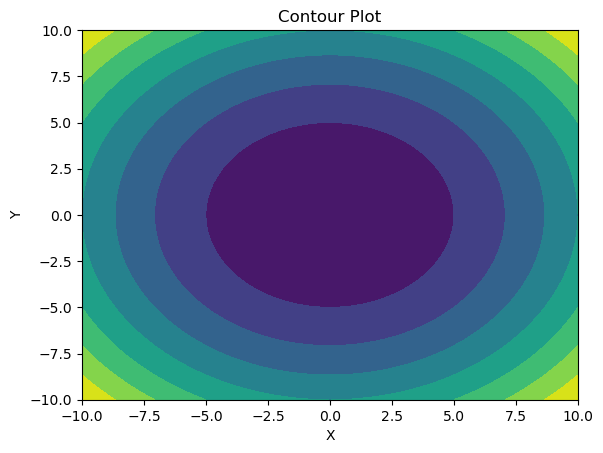

In [8]:
x = np.linspace(-10, 10, 1000) 
y = np.linspace(-10, 10, 1000) 
  
[X, Y] = np.meshgrid(x, y) 
Z = X**2 + Y**2
F = 2*X + 2*Y - 20

fig, axs = plt.subplots(1, 1)   
axs.contourf(X, Y, Z)
axs.set_title('Contour Plot') 
axs.set_xlabel('X') 
axs.set_ylabel('Y') 
plt.show() 